<a href="https://colab.research.google.com/github/TobiPrae/customer_segmentation/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import time

# magic word for producing visualizations in notebook
%matplotlib inline

import gc

# machine learning magic for unsupervised learning part
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# To pickle preparation models
from pickle import dump, load

# To identify elbow point
!pip install kneed
from kneed import KneeLocator

print("Libraries successfully imported")

Libraries successfully imported


In [76]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Everything successfully set up")

Everything successfully set up


# Load Data

In [3]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list[:5]:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: labels__customer_df.csv, id: 1HRwU-tuAsQM3p0PHo8SQRNrLBeaTKyLF
title: labels_df.csv, id: 1d1FtFETJ5u0_o7QvL43CFfxj_AQ_3Cz2
title: kmeans.pkl, id: 1gksupfPuiOA1jCTgIKYGh-HeA-yMyBpJ
title: pca.pkl, id: 1D4Ww-BDgGxpQpu3vbfK_PdvSatXQRIUW
title: df_azdias_scaled_80.csv, id: 1SZpXGVS2HOdnYDzWtoBxRV7l2NhhDrm-


In [4]:
# download demographic data
download_data = drive.CreateFile({'id': '135UcsbUyLcwS16QHa7lFcXHKhuy7HwWF'})
download_data.GetContentFile('azdias.csv')  
df_azdias = pd.read_csv('azdias.csv', engine="python", sep=';')

print(df_azdias.shape)

(891221, 366)


In [84]:
# download customer data
download_data = drive.CreateFile({'id': '1eDq76GDZLXeonowxPrbwF-EHZwvaENLK'})
download_data.GetContentFile('customers.csv')  
df_customers = pd.read_csv('customers.csv', engine="python", sep=';')

print(df_customers.shape)

(191652, 369)


In [6]:
# download attribute values and clean them
download_data = drive.CreateFile({'id': '1wFNhCQm7Cv9CGJ7Pm_RbtrJdnLb4zyuC'})
download_data.GetContentFile('attributes_values.xlsx')  
df_attributes_values = pd.read_excel('attributes_values.xlsx', names=["None", "attribute", "description", "value", "meaning"])
df_attributes_values = df_attributes_values.drop(columns=['None'])[1:]
# Forward filling the attribute values df for better filtering/slicing
df_attributes_values["attribute"] = df_attributes_values["attribute"].fillna(method="ffill")
df_attributes_values["description"] = df_attributes_values["description"].fillna(method="ffill")
print(df_attributes_values.shape)

(2258, 4)


In [7]:
# download attribute information levels and clean them
download_data = drive.CreateFile({'id': '1icPBxHTV0zysKvQSJhSDPDhyH8Qd3uqW'})
download_data.GetContentFile('information_levels_attributes.xlsx')  
df_information_levels = pd.read_excel('information_levels_attributes.xlsx', names=["None", "Information_Level", "attribute", "description", "additional_notes"])
df_information_levels = df_information_levels.drop(columns=["None"])[1:]
print(df_information_levels.shape)

(313, 4)


In [85]:
# download demographic data
download_data = drive.CreateFile({'id': '1QwV131IP74EHaBrKAnlcGk4EaMwBsTHE'})
download_data.GetContentFile('meta_data.xlsx')  
meta_data = pd.read_excel('meta_data.xlsx')
meta_data = meta_data.iloc[:365, :]
print(meta_data.shape)

(365, 16)


# Functions

In [9]:
def get_description(col):
  '''
  Gets description for given column.

  Args:
  - col: column name

  Returns:
  - description or "No description available."
  '''
  if(df_attributes_values.loc[df_attributes_values["attribute"] == col].shape[0] == 0):
    return "No description available."
  else:
    return df_attributes_values.loc[df_attributes_values["attribute"] == col]["description"].values[0]

In [ ]:
def create_meta_dataframe():
  '''
  Creates data frame with meta information.

  Args:
  - Nothing

  Returns:
  - meta_df
  '''
  meta_df = pd.DataFrame(df_azdias.columns.tolist())
  meta_df = meta_df.rename(columns={0: "column_name"})
  meta_df["na_percentage"] = meta_df["column_name"].apply(lambda x: round(df_azdias[x].isna().sum()/df_azdias.shape[0], 4))
  meta_df["dtypes"] =  meta_df["column_name"].apply(lambda x: set(df_azdias[x].map(type).tolist()))
  meta_df["n_dtypes"] = meta_df["column_name"].apply(lambda x: len(set(df_azdias[x].map(type).tolist())))
  meta_df["unique_values"] = meta_df["column_name"].apply(lambda x: len(df_azdias[x].value_counts()))
  meta_df["description"] =  meta_df["column_name"].apply(get_description)
  meta_df["action"] = "Keep"
  meta_df["reason"] = "None"
  return meta_df

In [10]:
def transform_PRAEGENDE_JUGENDJAHRE(x):
  '''
    Transform value for feature PRAEGENDE_JUGENDJAHRE.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2]):
    return 40
  elif(x in [3, 4]):
    return 50
  elif(x in [5, 6, 7]):
    return 60
  elif(x in [8, 9]):
    return 70
  elif(x in [10, 11, 12, 13]):
    return 80
  elif(x in [14, 15]):
    return 90

In [11]:
def transform_CAMEO_INTL_2015(x):
  '''
  Transform value for feature CAMEO_INTL_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(str(x)[0] == '1'):
    return '1'
  if(str(x)[0] == '2'):
    return '2'
  if(str(x)[0] == '3'):
    return '3'
  if(str(x)[0] == '4'):
    return '4'
  if(str(x)[0] == '5'):
    return '5'
  else:
    return np.nan

In [12]:
def transform_CAMEO_DEUG_2015(x):
  '''
  Transform value for feature CAMEO_DEUG_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x == 'X'):
    return np.nan
  else:
    return x

In [86]:
def transformation_pipeline(df, column_threshold = 0.3, row_threshold = 0.3):

  print(f"shape before: {df.shape}")

  # Drop ID column
  df = df.drop(columns="LNR")
  print("index droped")

  # Drop columns with nan percentage over certain threshold
  drop_columns = meta_data.loc[meta_data["na_percentage_azdias"] > column_threshold]["column_name"].tolist()
  df = df.drop(columns=drop_columns)
  print(f"columns with nan threshold of {column_threshold} droped: ")
  print(drop_columns)

  # Drop rows with nan percentage over certain threshold
  df["row_nan_percentage"] = pd.Series(df.index).apply(lambda x: df.iloc[x, :].isna().sum()/df.shape[1])
  df = df.loc[df["row_nan_percentage"] < row_threshold]
  print(f"rows with nan threshold of {row_threshold} droped")  

  ### Drop columns with unknown data types and no description ###

  unknown_cols = meta_data.loc[meta_data["type"] == "Unknown"]["column_name"].tolist()
  df_transformed = df.drop(columns=list(set(unknown_cols).intersection(set(df.columns))))
  print("columns with unknown datatype droped")

  ### Transformation of binary columns ###

  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].replace(2, 0) 
  df_transformed["GREEN_AVANTGARDE"] = df_transformed["GREEN_AVANTGARDE"].fillna(df_transformed["GREEN_AVANTGARDE"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].apply(lambda x: 1 if x == 'W' else (0 if 'O' else x))
  df_transformed["SOHO_KZ"] = df_transformed["SOHO_KZ"].fillna(df_transformed["SOHO_KZ"].mode().values[0])
  df_transformed["ANREDE_KZ"] = df_transformed["ANREDE_KZ"].fillna(df_transformed["ANREDE_KZ"].mode().values[0])
  df_transformed["OST_WEST_KZ"] = df_transformed["OST_WEST_KZ"].fillna(df_transformed["OST_WEST_KZ"].mode().values[0])
  print("binary columns transformed")

  ### Transformation of numerical columns ###

  numerical_columns = meta_data.loc[meta_data["type"] == "Numerical"]["column_name"].tolist()
  for col in list(set(numerical_columns).intersection(set(df_transformed.columns))):
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("numeric columns transformed")

  ### Transformation of ordinal columns ###

  # Transform ordinal columns that have no value or -1 for unknown
  ordinal_no_unknown_cols = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] != 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_no_unknown_cols = list(set(ordinal_no_unknown_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_no_unknown_cols:
    df_transformed[col] = df_transformed[col].fillna(df_transformed[col].median())
  print("ordinal columns that have no value for unkown transformed")

  # Transform ordinal colums that have 9 or -1 values for unknow
  ordinal_9_1_cols = meta_data.loc[(meta_data["9 unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_9_1_cols = list(set(ordinal_9_1_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_9_1_cols:
    df_transformed[col] = df_transformed[col].replace(9, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 9 or -1 values for unknow transformed")

  # Transform ordinal columns that have 0 or -1 values for unknown
  ordinal_0_1_cols = meta_data.loc[(meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Ordinal")]["column_name"].tolist()
  ordinal_0_1_cols = list(set(ordinal_0_1_cols).intersection(set(df_transformed.columns)))
  for col in ordinal_0_1_cols:
    df_transformed[col] = df_transformed[col].replace(0, np.nan).fillna(df_transformed[col].median())
  print("ordinal colums that have 0 or -1 values for unknow transformed")

  ### Transformation of categorical features ###

  # Transform categorical columns that have 0 values for unknown
  categorical_0_columns = meta_data.loc[(meta_data["9 unknown"] != 'x') & (meta_data["0  unknown"] == 'x') & (meta_data["type"] == "Categorical")]["column_name"].tolist()
  categorical_0_columns = list(set(categorical_0_columns).intersection(set(df_transformed.columns)))
  for col in categorical_0_columns:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan, 0: np.nan})
  print("categorical columns that have 0 values for unknown transformed")

  # Transform "PRAEGENDE_JUGENDJAHRE"
  df_transformed["PRAEGENDE_JUGENDJAHRE"] = df_transformed["PRAEGENDE_JUGENDJAHRE"].apply(transform_PRAEGENDE_JUGENDJAHRE)
  print('"PRAEGENDE_JUGENDJAHRE" transformed')

  # Transform "ZABEOTYP"
  df_transformed["ZABEOTYP"] = df_transformed["ZABEOTYP"].replace({9: np.nan})
  print('"ZABEOTYP" transformed')

  # Transform "D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"
  cat_temp = ["D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP"]
  cat_temp = list(set(cat_temp).intersection(set(df_transformed.columns)))
  for col in cat_temp:
    df_transformed[col] = df_transformed[col].replace({-1: np.nan})
  print('"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed')

  # Drop "CAMEO_DEU_2015" and "AGER_TYP"
  df_transformed = df_transformed.drop(columns=["CAMEO_DEU_2015", "AGER_TYP"])
  print('"CAMEO_DEU_2015" and "AGER_TYP" droped')

  # Transform "CAMEO_INTL_2015"
  df_transformed["CAMEO_INTL_2015"] = df_transformed["CAMEO_INTL_2015"].apply(transform_CAMEO_INTL_2015)
  print("CAMEO_INTL_2015 transformed")

  # Transform "CAMEO_DEUG_2015"
  df_transformed["CAMEO_DEUG_2015"] = df_transformed["CAMEO_DEUG_2015"].apply(transform_CAMEO_DEUG_2015)
  print("CAMEO_DEUG_2015 transformed")

  # Create dummies
  cat_cols = meta_data.loc[meta_data["type"] == "Categorical"]["column_name"].tolist()
  print(cat_cols)
  dummy_cols = list(set(cat_cols).intersection(set(df_transformed.columns)))
  print(dummy_cols)
  for col in dummy_cols:
    col_dum_df = pd.get_dummies(df_transformed[col], prefix=col, dummy_na=True)
    df_transformed = pd.concat([df_transformed, col_dum_df], axis=1)

  df_transformed = df_transformed.drop(columns=dummy_cols)
  print("Dummies created")

  # Transform everything to float
  df_transformed = df_transformed.astype(float)

  print(f"shape after: {df_transformed.shape}")
  return df_transformed



# Part 0: Clean and Standardize Data

### Transform data

In [15]:
# Transform df_azdias
df_azdias_transformed = transformation_pipeline(df_azdias, column_threshold = 0.2, row_threshold = 0.1)

shape before: (891221, 366)
index droped
columns with nan threshold of 0.2 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
rows with nan threshold of 0.1 droped
columns with unknown datatype droped
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_201

In [87]:
# Transform df_customers
df_customers = df_customers.drop(columns=["PRODUCT_GROUP", "CUSTOMER_GROUP", "ONLINE_PURCHASE"])
df_customers_transformed = transformation_pipeline(df_customers, column_threshold = 0.2, row_threshold = 0.1)

shape before: (191652, 366)
index droped
columns with nan threshold of 0.2 droped: 
['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP']
rows with nan threshold of 0.1 droped
columns with unknown datatype droped
binary columns transformed
numeric columns transformed
ordinal columns that have no value for unkown transformed
ordinal colums that have 9 or -1 values for unknow transformed
ordinal colums that have 0 or -1 values for unknow transformed
categorical columns that have 0 values for unknown transformed
"PRAEGENDE_JUGENDJAHRE" transformed
"ZABEOTYP" transformed
"D19_KONSUMTYP", "FINANZTYP", "GEBAEUDETYP", "GFK_URLAUBERTYP", "SHOPPER_TYP" transformed
"CAMEO_DEU_2015" and "AGER_TYP" droped
CAMEO_INTL_201

### Get different columns and add them

In [89]:
# Get different columns
set(scaled_df.columns).difference(set(df_customers_transformed.columns))

{'GEBAEUDETYP_5.0'}

In [91]:
# Get index of differenct column
scaled_df.columns.get_loc('GEBAEUDETYP_5.0') 

298

In [92]:
# Inset column
df_customers_transformed.insert(loc=298, column='GEBAEUDETYP_5.0', value=0)

### Scale demographic data

In [16]:
# Create and fit scaler
cols = df_azdias_transformed.columns.tolist()
scaler = StandardScaler()
scaler.fit(df_azdias_transformed.values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
# Save the scaler
dump(scaler, open('scaler.pkl', 'wb'))
model_files = drive.CreateFile({'title' : 'scaler.pkl'})
model_files.SetContentFile('scaler.pkl')
model_files.Upload()
drive.CreateFile({'id': model_files.get('scaler.pkl')})

GoogleDriveFile({'id': None})

In [18]:
# Scale features
scaled_features = scaler.transform(df_azdias_transformed.values)

# Free some memory
del df_azdias
del df_azdias_transformed
gc.collect()

# Create df
scaled_df = pd.DataFrame(scaled_features, columns=cols)

In [22]:
start = 0
step = 10000
end = step

for i in range(1, 81):
  if(i in [10, 20, 30, 40, 50, 60, 70, 80]):
    print(f"Slice {i}")
  scaled_df.iloc[start:end,:].to_csv(f"df_azdias_scaled_{i}.csv", index=False)
  files = drive.CreateFile({'title' : f"df_azdias_scaled_{i}.csv"})
  files.SetContentFile(f"df_azdias_scaled_{i}.csv")
  files.Upload()
  drive.CreateFile({'id': files.get(f"df_azdias_scaled_{i}.csv")})
  start += step
  end += step
print("upload completed")

Slice 10
Slice 20
Slice 30
Slice 40
Slice 50
Slice 60
Slice 70
Slice 80
upload completed


# Part 1: Customer Segmentation Report

### PCA Analysis

In [ ]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
ticker=0
data=dict()
for file1 in file_list:
  if(ticker == 90):
    break
  else:
    data[file1['title']] = file1['id']
  ticker+=1

In [ ]:
# Load data
download_data = drive.CreateFile({'id': data[f"df_azdias_scaled_{1}.csv"]})
download_data.GetContentFile(f"df_azdias_scaled_{1}.csv")  
scaled_df = pd.read_csv(f"df_azdias_scaled_{1}.csv")

for i in range(2, 81):
  if(i in [10, 20, 30, 40, 50, 60, 70, 80]):
    print(f"Slice {i}")
  download_data = drive.CreateFile({'id': data[f"df_azdias_scaled_{i}.csv"]})
  download_data.GetContentFile(f"df_azdias_scaled_{i}.csv")  
  temp = pd.read_csv(f"df_azdias_scaled_{i}.csv")

  scaled_df = pd.concat([scaled_df, temp], axis=0)

print(scaled_df.shape)
print(sum(scaled_df.isna().sum()))
scaled_df.head(3)

Slice 10
Slice 20
Slice 30
Slice 40
Slice 50
Slice 60
Slice 70
Slice 80
(785421, 385)
0


,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBE

In [23]:
explained_var = 0.9
pca = PCA(explained_var)
pca.fit(np.array(scaled_df))

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
# Save pca
dump(pca, open('pca.pkl', 'wb'))
model_files = drive.CreateFile({'title' : 'pca.pkl'})
model_files.SetContentFile('pca.pkl')
model_files.Upload()
drive.CreateFile({'id': model_files.get('pca.pkl')})

GoogleDriveFile({'id': None})

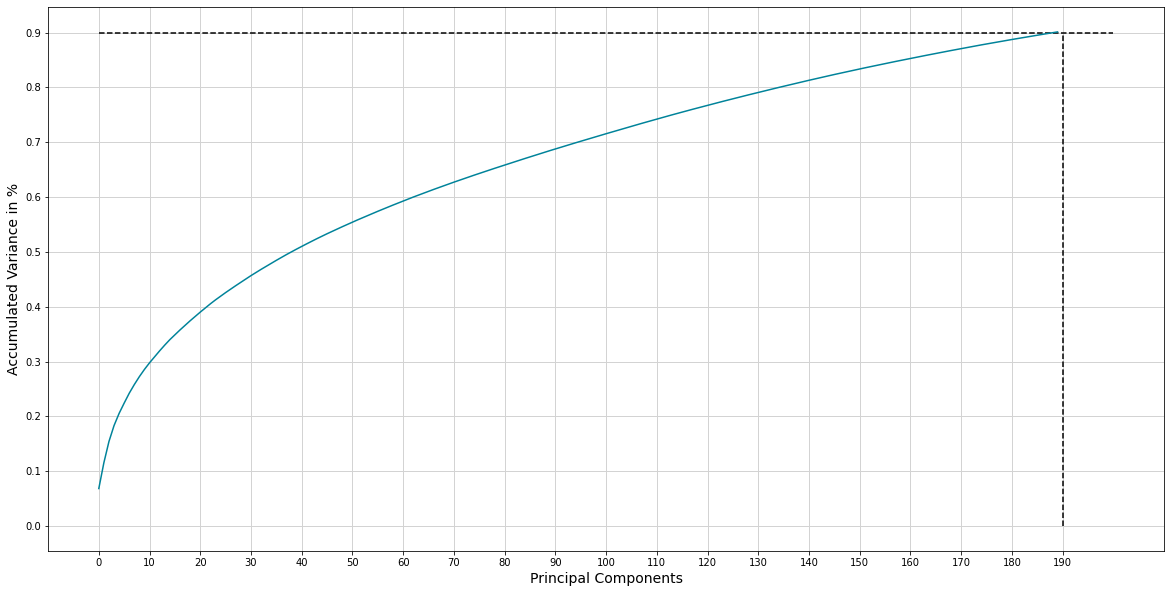

In [40]:
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.plot(np.cumsum(pca.explained_variance_ratio_), color='#00839A')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Accumulated Variance in %', fontsize=14)
plt.yticks(np.arange(0, 1, step=0.1))
plt.xticks(np.arange(0, 200, step=10))
ax.vlines(pca.n_components_, 0, 0.9, color='black', linestyle='--')
ax.hlines(explained_var, 0, 200, color='black', linestyle='--')
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

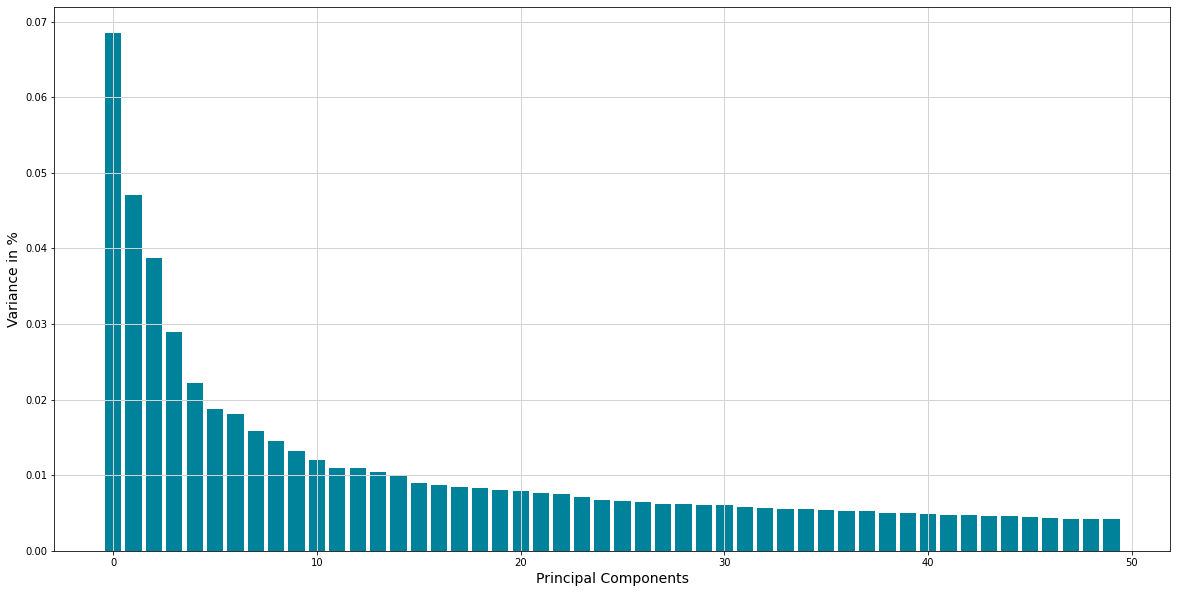

In [41]:
features = range(pca.n_components_)

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.bar(features[:50], pca.explained_variance_ratio_[:50], color='#00839A')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance in %', fontsize=14)
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

In [66]:
print(pca.explained_variance_ratio_[:4])

[0.0684943  0.0470646  0.03873299 0.02894438]


In [47]:
principal_component_1 = pca.components_[0]
principal_component_2 = pca.components_[1]
principal_component_3 = pca.components_[2]
principal_component_4 = pca.components_[3]

In [62]:
### Principal component 1
print("Principal component 1")

temp = list(principal_component_1)
pc_1_max_indices = []
pc_1_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_1_max_indices.append(max_index)
  pc_1_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 1:")
for i in pc_1_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 1:")
for i in pc_1_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 1
_______________________________________________________
High positive influence on principal component 1:
- MOBI_REGIO
- LP_LEBENSPHASE_GROB
- KBA05_ANHANG
_______________________________________________________
High negative influence on principal component 1:
- HH_EINKOMMEN_SCORE
- PLZ8_ANTG1
- OST_WEST_KZ


In [63]:
### Principal component 2
print("Principal component 2")

temp = list(principal_component_2)
pc_2_max_indices = []
pc_2_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_2_max_indices.append(max_index)
  pc_2_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 1:")
for i in pc_2_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 1:")
for i in pc_2_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 2
_______________________________________________________
High positive influence on principal component 1:
- KBA13_HERST_BMW_BENZ
- KBA13_SEG_MITTELKLASSE
- KBA13_MAZDA
_______________________________________________________
High negative influence on principal component 1:
- KBA13_SITZE_5
- KBA13_SITZE_4
- KBA13_SEG_WOHNMOBILE


In [64]:
### Principal component 3
print("Principal component 3")

temp = list(principal_component_3)
pc_3_max_indices = []
pc_3_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_3_max_indices.append(max_index)
  pc_3_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 3:")
for i in pc_3_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 3:")
for i in pc_3_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 3
_______________________________________________________
High positive influence on principal component 3:
- ONLINE_AFFINITAET
- FINANZ_MINIMALIST
- D19_GESAMT_ANZ_24
_______________________________________________________
High negative influence on principal component 3:
- D19_GESAMT_ONLINE_DATUM
- D19_VERSAND_OFFLINE_DATUM
- D19_GESAMT_DATUM


In [65]:
### Principal component 4
print("Principal component 4")

temp = list(principal_component_4)
pc_4_max_indices = []
pc_4_min_indices = []


for i in range(3):
 
  max_value = max(temp)
  min_value = min(temp)
  max_index = temp.index(max_value)
  min_index = temp.index(min_value)
  pc_4_max_indices.append(max_index)
  pc_4_min_indices.append(min_index)
  temp.pop(max_index)
  temp.pop(min_index)

print("_______________________________________________________")

print("High positive influence on principal component 4:")
for i in pc_4_max_indices:
  print(f"- {scaled_df.columns[i]}")

print("_______________________________________________________")

print("High negative influence on principal component 4:")
for i in pc_4_min_indices:
  print(f"- {scaled_df.columns[i]}")

Principal component 4
_______________________________________________________
High positive influence on principal component 4:
- ALTERSKATEGORIE_GROB
- FINANZ_UNAUFFAELLIGER
- RETOURTYP_BK_S
_______________________________________________________
High negative influence on principal component 4:
- FINANZ_SPARER
- SEMIO_RAT
- SEMIO_PFLICHT


In [67]:
pca_components = pd.DataFrame(pca.transform(np.array(scaled_df)))

### Define clusters and apply kmeans model to demographic and to customer data

In [68]:
k_range = range(1, 26)
inertia_list = []
for k in k_range:
  start_time = time.time()
  print(f"k = {k}")

  # Build model
  model = KMeans(n_clusters=k)
    
  # Fit model to samples
  model.fit(pca_components)

  # Append inertia
  inertia_list.append(model.inertia_)

  end_time = time.time()
  print(f"total time taken model fitting with k = {k}: {end_time - start_time} seconds (inertia {model.inertia_})")
  print("________________________________________________________________________________")

k = 1
total time taken model fitting with k = 1: 17.48241138458252 seconds (inertia 249904426.70263654)
________________________________________________________________________________
k = 2
total time taken model fitting with k = 2: 82.69333744049072 seconds (inertia 236357555.78837848)
________________________________________________________________________________
k = 3
total time taken model fitting with k = 3: 134.0977544784546 seconds (inertia 230042898.76172063)
________________________________________________________________________________
k = 4
total time taken model fitting with k = 4: 181.87414932250977 seconds (inertia 225473565.41444647)
________________________________________________________________________________
k = 5
total time taken model fitting with k = 5: 204.69613671302795 seconds (inertia 221935325.01283696)
________________________________________________________________________________
k = 6
total time taken model fitting with k = 6: 270.3220920562744 second

[249904426.70263654, 236357555.78837848, 230042898.76172063, 225473565.41444647, 221935325.01283696, 219458170.76433942, 217146530.07857728, 215339186.5471797, 213700107.93316317, 212008967.7597235, 210753215.4772089, 208849149.29825446, 207897929.4418377, 208059941.71400428, 206308601.0505295, 204882934.36994138, 204810400.01672164, 203375228.7461338, 202962661.72393396, 202944667.4249806, 202251996.49362296, 201807669.10658404, 200608983.59538993, 200791228.77332386, 199936277.72829846]


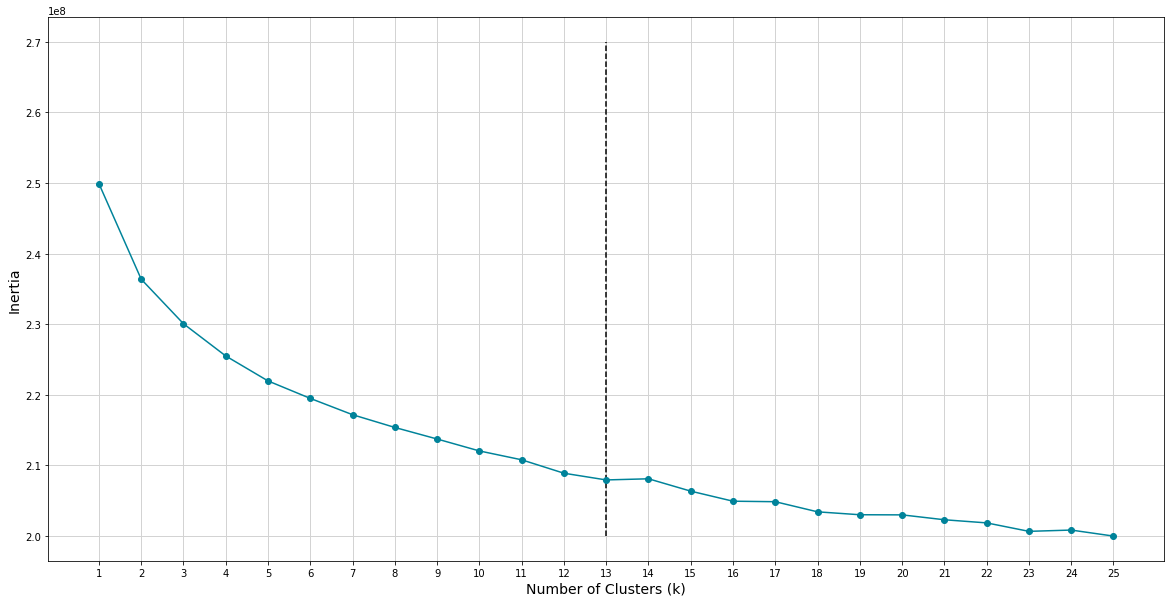

In [71]:
print(inertia_list)

# Using kneedle to determine optimal number of cluster based on "elbow method"
#kneedle = KneeLocator(k_range, inertia_list, curve="convex", direction="decreasing")
#elbow_point = kneedle.elbow
elbow_point = 13

fig, ax = plt.subplots(figsize=(20, 10))
fig = plt.plot(k_range, inertia_list, '-o', color='#00839A')
plt.xlabel('Number of Clusters (k)', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.xticks(k_range)
ax.vlines(elbow_point, 200000000, 270000000, color='black', linestyle='--')
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")

In [73]:
### Train model with k = elbow point

# Build model
model = KMeans(n_clusters=13)
    
# Fit model to samples
model.fit(pca_components)

# Get labels
labels = model.labels_

# Transform labels to df
labels_df = pd.DataFrame(labels)

In [77]:
# Save kmeans
dump(model, open('kmeans.pkl', 'wb'))
model_files = drive.CreateFile({'title' : 'kmeans.pkl'})
model_files.SetContentFile('kmeans.pkl')
model_files.Upload()
drive.CreateFile({'id': model_files.get('kmeans.pkl')})

GoogleDriveFile({'id': None})

In [78]:
# Save labels_df
labels_df.to_csv("labels_df.csv")
files = drive.CreateFile({'title' : "labels_df.csv"})
files.SetContentFile("labels_df.csv")
files.Upload()
drive.CreateFile({'id': files.get("labels_df.csv.csv")})

GoogleDriveFile({'id': None})

In [ ]:
# Download scaler
download_data = drive.CreateFile({'id': '1xc8Es1Llmcn_LmEy4U1vGX1YJHRtLWz0'})
download_data.GetContentFile('scaler.pkl')  
scaler = load(open('scaler.pkl', 'rb'))

In [ ]:
# Download pca
download_data = drive.CreateFile({'id': '1D4Ww-BDgGxpQpu3vbfK_PdvSatXQRIUW'})
download_data.GetContentFile('pca.pkl')  
pca = load(open('pca.pkl', 'rb'))

In [ ]:
# Download kmeans
download_data = drive.CreateFile({'id': '1gksupfPuiOA1jCTgIKYGh-HeA-yMyBpJ'})
download_data.GetContentFile('kmeans.pkl')  
kmeans = load(open('kmeans.pkl', 'rb'))

In [93]:
# Scale features
cols = df_customers_transformed.columns.tolist()
scaled_features = scaler.transform(df_customers_transformed.values)

# Create df
scaled_df = pd.DataFrame(scaled_features, columns=cols)
scaled_df.head(3)

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,

In [94]:
# Transform customer data
pca_components = pd.DataFrame(pca.transform(np.array(scaled_df)))

In [96]:
labels_customer = model.predict(pca_components)

In [99]:
labels_customer_df = pd.DataFrame(labels_customer)

In [100]:
# Save labels_df
labels_customer_df.to_csv("labels_customer_df.csv")
files = drive.CreateFile({'title' : "labels_customer_df.csv"})
files.SetContentFile("labels_customer_df.csv")
files.Upload()
drive.CreateFile({'id': files.get("labels_customer_df.csv")})

GoogleDriveFile({'id': None})

In [102]:
# Get list of every available file in google drive
file_list = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
for file1 in file_list[:5]:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: labels_customer_df.csv, id: 1wZvq8mxuh8YTAj1K4BFpovBBTAvcb9CX
title: labels_df.csv, id: 1mki9mfFxaOxyuhUx7xDvX4McPb59vFL9
title: kmeans.pkl, id: 1_q3o5PgJaeKdJGw0JOlmmAUvb-h8zkMJ
title: pca.pkl, id: 1dmDhrqjg8h7vGflKIlqCyWMSD6RFaI_V
title: df_azdias_scaled_80.csv, id: 1tVC_9TQyGEHSFkxEqg-qDZBKgUZ1fxy2


In [103]:
# Download demographic labels
download_data = drive.CreateFile({'id': '1mki9mfFxaOxyuhUx7xDvX4McPb59vFL9'})
download_data.GetContentFile('labels_df.csv')  
labels_df = pd.read_csv('labels_df.csv', engine="python")
len = labels_df.shape[0]
labels_df = pd.DataFrame(labels_df['0'].value_counts())
labels_df["labels"] = labels_df.index
labels_df["proportion"] = labels_df['0'].apply(lambda x: x/len)
labels_df

,0,labels,proportion
6,97425,6,0.129670
4,93352,4,0.124249
1,74754,1,0.099495
2,70502,2,0.093836
5,57790,5,0.076917
0,54660,0,0.072751
3,52712,3,0.070158
11,52537,11,0.069925
7,47821,7,0.063648
12,47256,12,0.062896


In [105]:
# Download customer labels
download_data = drive.CreateFile({'id': '1wZvq8mxuh8YTAj1K4BFpovBBTAvcb9CX'})
download_data.GetContentFile('labels_customer_df.csv')  
labels_customer_df = pd.read_csv('labels_customer_df.csv', engine="python")
len = labels_customer_df.shape[0]
labels_customer_df = pd.DataFrame(labels_customer_df['0'].value_counts())
labels_customer_df["labels"] = labels_customer_df.index
labels_customer_df = labels_customer_df.append(pd.DataFrame([[0.0, 5.0]], columns=["0", "labels"]))
labels_customer_df["proportion"] = labels_customer_df['0'].apply(lambda x: x/len)
labels_customer_df

,0,labels,proportion
5,35461.0,5.0,0.262394
6,28609.0,6.0,0.211693
1,28255.0,1.0,0.209073
4,14026.0,4.0,0.103786
9,8038.0,9.0,0.059477
8,5718.0,8.0,0.042310
12,3699.0,12.0,0.027371
7,3078.0,7.0,0.022776
3,3024.0,3.0,0.022376
11,2492.0,11.0,0.018440


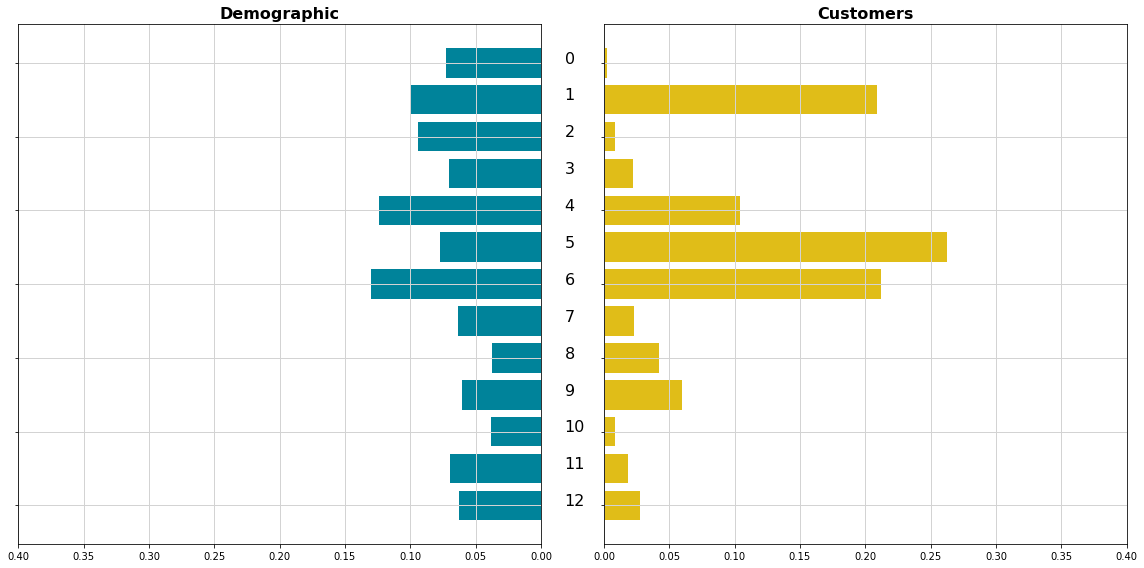

In [112]:
fig = plt.figure(figsize=(16, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

ax0 = plt.subplot(gs[0])
ax0.barh(labels_df["labels"], labels_df["proportion"], color='#00839A')
ax0.set_title('Demographic', fontsize=16, fontweight='bold')
ax0.set_xlim([0, 0.4])
ax0.tick_params(axis='both', which='major')
plt.gca().invert_yaxis()
plt.grid(color='grey', linestyle='-', linewidth=.1)
plt.gca().invert_xaxis()
plt.gca().axes.yaxis.set_ticklabels([])
ax0.grid(color='lightgrey', linestyle='-', linewidth=1)
ax0.set_facecolor("white")
plt.tight_layout()

ax1 = plt.subplot(gs[1])
ax1.barh(labels_customer_df["labels"], labels_customer_df["proportion"], color='#E0BD18')
ax1.set_title('Customers', fontsize=16, fontweight='bold')
ax1.set_xlim([0, 0.4])
ax1.tick_params(axis='both', which='major')
plt.gca().invert_yaxis()
plt.gca().axes.yaxis.set_ticklabels([])

for i in range(0, 13):
  ax1.text(-0.03, i, f"{i}", fontsize=16)

ax1.grid(color='lightgrey', linestyle='-', linewidth=1)
ax1.set_facecolor("white")
plt.tight_layout()

In [113]:
proportions = dict()

for cluster in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]:

  customer_proportion = labels_customer_df.loc[labels_customer_df["labels"] == cluster]["proportion"].values[0]
  demographic_proportion = labels_df.loc[labels_df["labels"] == cluster]["proportion"].values[0]
  diff = customer_proportion - demographic_proportion

  proportions[cluster] = diff

ratio_df = pd.DataFrame.from_dict(proportions, orient='index', columns=["prop_ratio"])
ratio_df

,prop_ratio
0,-0.070102
1,0.109578
2,-0.085031
3,-0.047782
4,-0.020463
5,0.185477
6,0.082023
7,-0.040873
8,0.004756
9,-0.001286


(-0.1, 0.2)

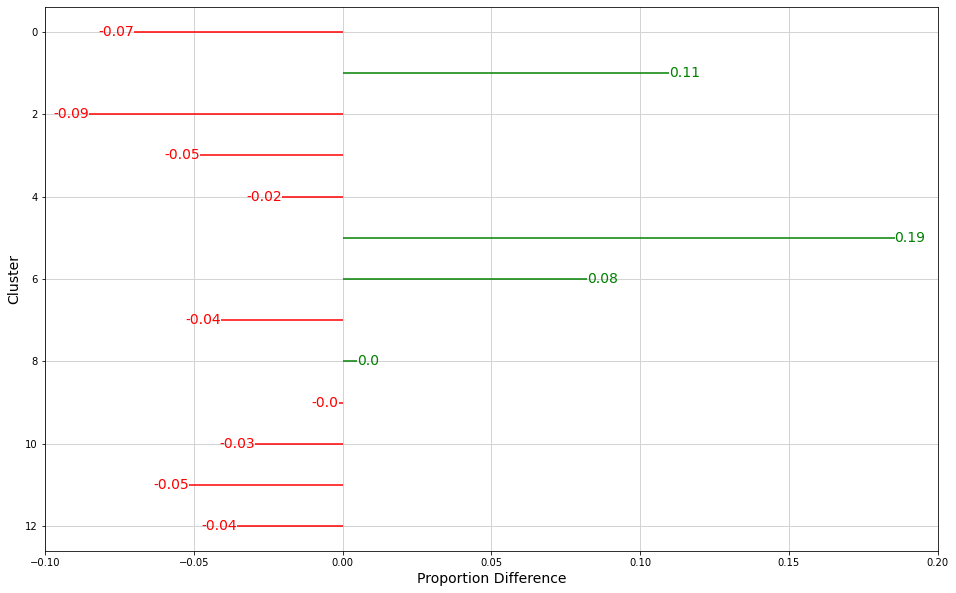

In [115]:
# Colorize red for negative and green for positive ratio
ratio_df['colors'] = ['red' if x < 0 else 'green' for x in ratio_df['prop_ratio']]

fig, ax = plt.subplots(figsize=(16, 10))
ax.invert_yaxis()

ax.hlines(y=ratio_df.index, xmin=0, xmax=ratio_df["prop_ratio"], color=ratio_df["colors"])
for x, y, tex in zip(ratio_df["prop_ratio"], ratio_df.index, ratio_df["prop_ratio"]):
    t = plt.text(x, y, round(tex, 2), horizontalalignment='right' if x < 0 else 'left', 
                 verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':14})

plt.xlabel("Proportion Difference", fontsize=14)
plt.ylabel("Cluster", fontsize=14)
ax.grid(color='lightgrey', linestyle='-', linewidth=1)
ax.set_facecolor("white")
plt.xlim(-0.1, 0.2)

### Analyze features for specific clusters

In [121]:
download_data = drive.CreateFile({'id': '1wZvq8mxuh8YTAj1K4BFpovBBTAvcb9CX'})
download_data.GetContentFile('labels_customer_df.csv')  
labels_customer_df = pd.read_csv('labels_customer_df.csv', engine="python")
print(labels_customer_df.shape)

(135144, 2)


In [122]:
df_customers_transformed["label"] = labels_customer_df["0"]
print(df_customers_transformed.shape)
df_customers_transformed.head(3)

(135144, 373)


,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,

In [128]:
df_customers_transformed_grouped = df_customers_transformed.groupby('label').mean()
df_customers_transformed_grouped

,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_REGIO,ONLINE_AFFINITAET,ORTSGR_KLS9,OST_WEST_KZ,

In [129]:
for col in df_customers_transformed_grouped.columns:
  df_customers_transformed_grouped[col] = df_customers_transformed_grouped[col]/df_customers_transformed[col].mean()

df_customers_transformed_grouped[["MOBI_REGIO", "LP_LEBENSPHASE_GROB", "KBA05_ANHANG"]]

,MOBI_REGIO,LP_LEBENSPHASE_GROB,KBA05_ANHANG
label,,,
0.0,0.957582,1.079423,0.873286
1.0,0.999056,1.002316,0.999776
2.0,0.989414,0.966937,1.015733
3.0,0.994688,0.977466,0.997443
4.0,0.997601,0.986908,0.989524
5.0,1.002057,1.001931,1.002069
6.0,1.000264,1.005683,0.998968
7.0,1.015067,1.001219,1.016017
8.0,0.998312,1.001800,1.008123


In [56]:
ranking_df = pd.DataFrame(df_customers_transformed_grouped.idxmax(), columns=["cluster"]).sort_values(by="cluster", ascending=False)
ranking_df.value_counts()

cluster
2.0        100
0.0        100
4.0         68
3.0         50
1.0         22
7.0         21
6.0         20
dtype: int64

In [58]:
df_customers_transformed_grouped.T.corr()

label,0.0,1.0,2.0,3.0,4.0,6.0,7.0
label,,,,,,,
0.0,1.000000,0.213925,-0.655525,-0.222896,0.375586,-0.189430,-0.152333
1.0,0.213925,1.000000,-0.311019,-0.317466,-0.194013,0.161139,-0.653929
2.0,-0.655525,-0.311019,1.000000,0.295065,-0.327040,0.009333,0.150113
3.0,-0.222896,-0.317466,0.295065,1.000000,0.009077,-0.691639,0.035106
4.0,0.375586,-0.194013,-0.327040,0.009077,1.000000,-0.391700,0.100225
6.0,-0.189430,0.161139,0.009333,-0.691639,-0.391700,1.000000,-0.193686
7.0,-0.152333,-0.653929,0.150113,0.035106,0.100225,-0.193686,1.000000


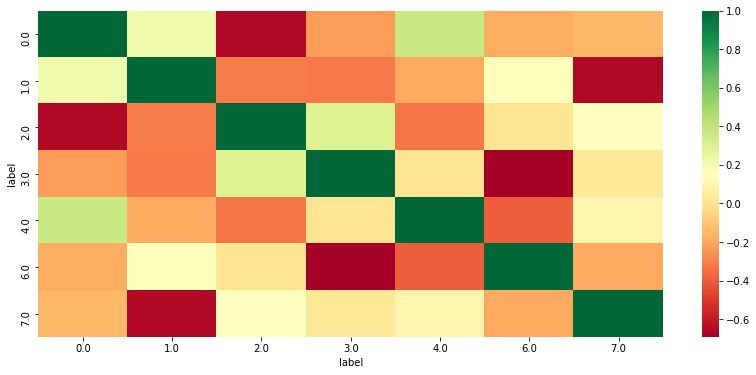

In [68]:
fig, ax = plt.subplots(figsize=(14, 6))
fig = sns.heatmap(df_customers_transformed_grouped.T.corr(), cmap="RdYlGn")

In [27]:
download_data = drive.CreateFile({'id': '1d1FtFETJ5u0_o7QvL43CFfxj_AQ_3Cz2'})
download_data.GetContentFile('labels_df.csv')
labels_df = pd.read_csv('labels_df.csv', engine="python")
print(labels_df.shape)

(785421, 2)


In [28]:
df_azdias_transformed["label"] = labels_df["0"]
print(df_azdias_transformed.shape)
df_azdias_transformed.head(3)

(785421, 386)


,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBE

In [35]:
df_customers_transformed = df_customers_transformed.groupby('label').mean()

In [36]:
df_customers_transformed

,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,BALLRAUM,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,GEBAEUDETYP_RASTER,GEBURTSJAHR,GREEN_AVANTGARDE,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KKK,KONSUMNAEHE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBE

In [73]:
df_azdias_by_label.iloc[1.0, ]

NameError: ignored

In [ ]:
for col in 

In [72]:
df_azdias_transformed["ALTER_HH"].mean()

10.90372679110948

# Functions

In [ ]:
def engineer_CAMEO_INTL_2015(x):
  '''
  Transform value for feature CAMEO_INTL_2015.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if((x == 'X') | (x == 'XX')):
    return np.nan
  if(str(x)[0] == '1'):
    return '1'
  if(str(x)[0] == '2'):
    return '2'
  if(str(x)[0] == '3'):
    return '3'
  if(str(x)[0] == '4'):
    return '4'
  if(str(x)[0] == '5'):
    return '5'
  else:
    return np.nan

In [ ]:
def engineer_OST_WEST_KZ(x):
  '''
  Transform value for feature OST_WEST_KZ.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x == 'W'):
    return 1
  elif(x == 'O'):
    return 0
  else:
    return np.nan

In [ ]:
def engineer_PRAEGENDE_JUGENDJAHRE(x):
  '''
    Transform value for feature PRAEGENDE_JUGENDJAHRE.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2]):
    return 40
  elif(x in [3, 4]):
    return 50
  elif(x in [5, 6, 7]):
    return 60
  elif(x in [8, 9]):
    return 70
  elif(x in [10, 11, 12, 13]):
    return 80
  elif(x in [14, 15]):
    return 90
  else:
    return np.nan

In [ ]:
def engineer_ALTER_HH(x):
  '''
  Transform value for feature ALTER_HH.

  Args:
  - x: Cell value

  Returns:
  - Transformed x
  '''
  if(x in [1, 2, 3]):
    return 10
  elif(x in [3, 4, 5]):
    return 20
  elif(x in [6, 7]):
    return 30
  elif(x in [8, 9]):
    return 40
  elif(x in [10, 11]):
    return 50
  elif(x in [12, 13]):
    return 60
  elif(x in [14, 15]):
    return 70
  elif(x in [16, 17]):
    return 80
  elif(x in [18, 19]):
    return 90
  elif(x in [20, 21]):
    return 100
  else:
    return np.nan
